In [18]:
import pandas as pd
import pdb
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.manifold import MDS 
from sklearn.cluster import KMeans
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)

In [19]:
#data  = pd.read_csv("data/featureslogfile_Budget_500_vs_Budget_500_GPM100_FG1E_NoSelfPlay.txt", sep = '\t')
data  = pd.read_csv("data/2Player_FG1E_Supply_AllYears_Traces.txt", sep = ' ')
print(data)
print(data.columns)

      GameID   AgentName  Player  Round  TotalRounds  FinalScore  Win  CELLAR  \
0          0  Silvermink       0      0           17          33  1.0       0   
1          0     Draggor       1      0           16          21  0.0       1   
2          0  Silvermink       0      1           17          33  1.0       1   
3          0     Draggor       1      1           16          21  0.0       1   
4          0  Silvermink       0      2           17          33  1.0       1   
...      ...         ...     ...    ...          ...         ...  ...     ...   
6433     148     mazungu       1     14           16          25  0.0       1   
6434     148     mazgirl       0     15           17          31  1.0       1   
6435     148     mazungu       1     15           16          25  0.0       1   
6436     148     mazgirl       0     16           17          31  1.0       1   
6437     148     mazungu       1     16           16          25  0.0       1   

      MARKET  MILITIA  ... 

In [20]:
#LOGS_FROM_TAG = False #if false, logs are from parsed online player logs
LOGS_FROM_TAG = False

NOOFPLAYERS = 2 #note, keep this fixed and dont change it - we always assume there are only two players
agents = ['MCTS_Medium_A', 'MCTS_Medium_B'] #arbitrary labels for players (whether AI based or not)

#if using TAG, parameters for round robin tournament
games_per_matchup = 100
self_play = False
NoOfGames = 2 * games_per_matchup
if self_play == True:
    NoOfGames = 4 * games_per_matchup
    
#if not using TAG, determine no of games 
if LOGS_FROM_TAG == False:
    NoOfGames = data['GameID'].max()  + 1 #GameID starts at zero

In [21]:
#define columns of interest 
#card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_SD = ['ARTISAN', 'BANDIT', 'BUREAUCRAT', 'CHAPEL', 'FESTIVAL', 'GARDENS', 'SENTRY', 'THRONE_ROOM', 'WITCH',
                 'WORKSHOP', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_FG1E = ['CELLAR','MARKET','MILITIA','MINE','MOAT','REMODEL','SMITHY','VILLAGE',
                'WOODCUTTER','WORKSHOP', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_SD_reduced = ['GARDENS', 'WORKSHOP','PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
#card_types = card_types_SD_reduced 
card_types = card_types_FG1E
index_cols = ['Player', 'GameID'] #used to group traces
non_card_types_round_indep_cols = ['AgentName', 'Win', 'FinalScore', 'TotalRounds'] #additional round indepedent values we want to investigate
cols = index_cols + non_card_types_round_indep_cols + ['Round'] + card_types #final set of cols to keep

In [22]:
#label all games with corresponding agent names

if LOGS_FROM_TAG == True:
    #first generate match-ups
    matchups = []
    if self_play:
        for agent1 in agents:
            for agent2 in agents:
                matchups.append((agent1, agent2))
    else:
        matchups = list(itertools.permutations(agents, 2))

    #function to map gameID to match-up
    def gameID_to_matchup(game_id, player_no, matchup_list, no_games_per_matchup, min_game_id):
        game_group = int((game_id - min_game_id)/no_games_per_matchup)
        matchup = matchup_list[game_group]
        agent1, agent2 = matchup
        if player_no == 0:
            return agent1
        else:
            return agent2

    #add agent names to data set
    min_GameID = data['GameID'].min()
    data['AgentName'] = data.apply(lambda row: gameID_to_matchup(row['GameID'], row['Player'], matchups, games_per_matchup, min_GameID), axis = 1)                         

In [23]:
#we can only record events each turn so we need to use the final turn in each round for each player to determine their
#deck at the end of the round
if LOGS_FROM_TAG:
    print(data['Turn'].unique())
    data = data[data['Turn'] == 1]

In [24]:
#all play taces in a single data frame
traces = data.loc[:, cols]
print(traces)

      Player  GameID   AgentName  Win  FinalScore  TotalRounds  Round  CELLAR  \
0          0       0  Silvermink  1.0          33           17      0       0   
1          1       0     Draggor  0.0          21           16      0       1   
2          0       0  Silvermink  1.0          33           17      1       1   
3          1       0     Draggor  0.0          21           16      1       1   
4          0       0  Silvermink  1.0          33           17      2       1   
...      ...     ...         ...  ...         ...          ...    ...     ...   
6433       1     148     mazungu  0.0          25           16     14       1   
6434       0     148     mazgirl  1.0          31           17     15       1   
6435       1     148     mazungu  0.0          25           16     15       1   
6436       0     148     mazgirl  1.0          31           17     16       1   
6437       1     148     mazungu  0.0          25           16     16       1   

      MARKET  MILITIA  ... 

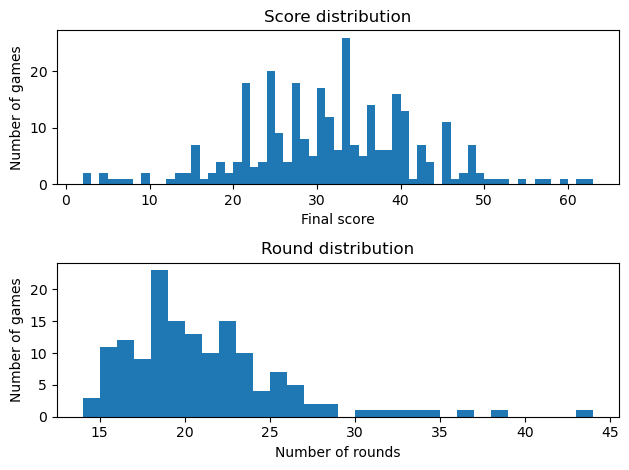

In [25]:
#plot score and round distributions
fig, axs = plt.subplots(2, 1)
grouped_data = traces.groupby('GameID')
score_data = grouped_data['FinalScore'].unique().explode()
axs[0].hist(score_data, bins=np.arange(score_data.min(), score_data.max()+1))
axs[0].set_xlabel('Final score')
axs[0].set_ylabel('Number of games')
axs[0].set_title('Score distribution')
round_data = traces.groupby('GameID')['Round'].max()
axs[1].hist(round_data, bins=np.arange(round_data.min(), round_data.max()+1))
axs[1].set_xlabel('Number of rounds')
axs[1].set_ylabel('Number of games')
axs[1].set_title('Round distribution')
fig.tight_layout() 

In [26]:
#we need to make sure all games have the same number of rounds in them
gameLengths = traces.groupby(['GameID'])['Round'].max()
maxNoOfRounds = int(gameLengths.max()) + 1 #round counter starts at zero
print(maxNoOfRounds)

45


In [27]:
def copy_final_deck_at_game_end(group, roundMax, noPlayers):
    #This function repeatedly copies the final decks of two players at the game end, so that the game is extended to 
    #have roundMax rounds
    final_round = int(group['Round'].max())
    if (roundMax-1) == final_round:
        #in this case we dont need to extend the play trace
        return group
    else:
        final_row_copy = pd.concat([group.iloc[-noPlayers:]] * ((roundMax-1) - final_round), ignore_index=True)
        #we need to update the Round counter so that every other row it increments by one
        final_row_copy['Round'] = [final_round + 1 + i // 2 for i in range(((roundMax-1) - final_round)*2)]
        return pd.concat([group, final_row_copy], ignore_index=True)

In [28]:
NoGamesDropped = 0
extended_traces = traces.groupby('GameID').apply(copy_final_deck_at_game_end, maxNoOfRounds, NOOFPLAYERS).reset_index(drop = True)
print(extended_traces)
print("Expected no rows: " + str(maxNoOfRounds*NOOFPLAYERS*(NoOfGames-NoGamesDropped)))
print("Expected no of cols: " + str(len(card_types)+7))
print(extended_traces.shape)

       Player  GameID   AgentName  Win  FinalScore  TotalRounds  Round  \
0           0       0  Silvermink  1.0          33           17      0   
1           1       0     Draggor  0.0          21           16      0   
2           0       0  Silvermink  1.0          33           17      1   
3           1       0     Draggor  0.0          21           16      1   
4           0       0  Silvermink  1.0          33           17      2   
...       ...     ...         ...  ...         ...          ...    ...   
13405       1     148     mazungu  0.0          25           16     42   
13406       0     148     mazgirl  1.0          31           17     43   
13407       1     148     mazungu  0.0          25           16     43   
13408       0     148     mazgirl  1.0          31           17     44   
13409       1     148     mazungu  0.0          25           16     44   

       CELLAR  MARKET  MILITIA  ...  VILLAGE  WOODCUTTER  WORKSHOP  CURSE  \
0           0       0        0  ..

In [29]:
#next we need to flatten this dataframe so that each trace is a single row.
#We also drop the round label as it is redundant
#and it will get reintroduced when flattening through the revised column names

#given a dictionary whose elements are lists of length two, grab the other element not given by elem, used in code
#below
def other_dict_element(my_dict, my_key, my_elem):
    index_of_given_element = my_dict[my_key].index(my_elem)
    index_of_other_element =  1 if (index_of_given_element == 0) else 0
    return my_dict[my_key][index_of_other_element]

#first create dataframe consisting of only non card type data types that are round 
#independent
non_card_data_round_indep = extended_traces[index_cols + non_card_types_round_indep_cols].drop_duplicates()

#next need to Group by Player and GameID and then flatten card data by round
traces_tmp = extended_traces[index_cols + card_types]
cols = [card_types[i] + "_R" + str(r) 
        for r in range(0, maxNoOfRounds) for i in range(0, len(card_types))] 

extended_traces_flat = traces_tmp.groupby(index_cols).apply(lambda df: df[card_types].values.flatten())
extended_traces_flat = pd.DataFrame(extended_traces_flat, columns = ['Trace']).reset_index()
extended_traces_flat = pd.concat([extended_traces_flat[index_cols], extended_traces_flat['Trace'].apply(pd.Series)], axis=1)
extended_traces_flat.columns = index_cols + cols

#next we add back in the round independent data
extended_traces_flat = pd.merge(non_card_data_round_indep, extended_traces_flat, on = index_cols)
                                 
#finally we also add the name of the agent of the opponent 
extended_traces_flat['Opponent'] = extended_traces_flat.apply(lambda row: 1.0 if row['Player'] == 0.0 else 0.0, axis = 1)
if LOGS_FROM_TAG:
    extended_traces_flat['AgentNameOpponent'] = extended_traces_flat.apply(lambda row: gameID_to_matchup(row['GameID'], row['Opponent'], matchups, games_per_matchup, min_GameID), axis = 1)  
else:
    gameid_to_players_dict = extended_traces_flat.groupby('GameID')['AgentName'].apply(list).to_dict()
    extended_traces_flat['AgentNameOpponent'] = extended_traces_flat.apply(lambda row: 
                            other_dict_element(gameid_to_players_dict, row['GameID'], row['AgentName']), axis = 1)   

In [30]:
#function to compare a pair of play traces
def deck_evol_comparison(trace_list, label_list, cardTypes, maxRounds, legendOn = True):
    #look at evolution of number of cards of each type per round
    noOfCardTypes = len(cardTypes)
    noOfSubPlotCols = 5
    noOfSubPlotRows = math.floor(noOfCardTypes/noOfSubPlotCols) + 1
    fig, axs = plt.subplots(noOfSubPlotRows, noOfSubPlotCols, figsize = (10,10))
    for i in range(0,noOfSubPlotRows):
        for j in range(0,noOfSubPlotCols):
            cardIndex = noOfSubPlotRows*j + i
            if cardIndex >= len(cardTypes):
                axs[i,j].set_visible(False)
            else:
                cardType = cardTypes[cardIndex]
                card_col = [cardType + "_R" + str(r) for r in range(0,maxRounds)]
                card_max = 0
                for (index, trace) in enumerate(trace_list):
                    axs[i,j].plot(range(0,maxRounds), trace[card_col].iloc[0], label = label_list[index])
                    tmp_card_max = int(trace[card_col].iloc[0].max())
                    if tmp_card_max > card_max:
                        card_max = tmp_card_max
                
                #set labels and limits
                axs[i,j].set_title(cardType)
                axs[i,j].set_xlabel('Round')
                axs[i,j].set_ylim((0,card_max+2))
                axs[i,j].set_xticks(ticks = range(0, maxRounds,10))
            
            #tighten subplots layout
            fig.tight_layout() 
            
    #add overal legend to figure
    if legendOn:
        axs[0,noOfSubPlotRows - 1].legend(loc = (-0.2,-0.8))

Max score gameID: 67
Max round gameID: 34
     Player  GameID                   AgentName  Win  FinalScore  TotalRounds  \
134       0      67  ♥~Pretty Pretty Princess~♥  1.0          63           26   
135       1      67                       bennu  0.0          15           25   

     CELLAR_R0  MARKET_R0  MILITIA_R0  MINE_R0  ...  WORKSHOP_R44  CURSE_R44  \
134          0          0           0        0  ...             0          0   
135          0          0           0        0  ...             0          0   

     PROVINCE_R44  DUCHY_R44  ESTATE_R44  GOLD_R44  SILVER_R44  COPPER_R44  \
134             8          4           3         3           1           3   
135             0          4           3         5           4           0   

     Opponent           AgentNameOpponent  
134       1.0                       bennu  
135       0.0  ♥~Pretty Pretty Princess~♥  

[2 rows x 773 columns]


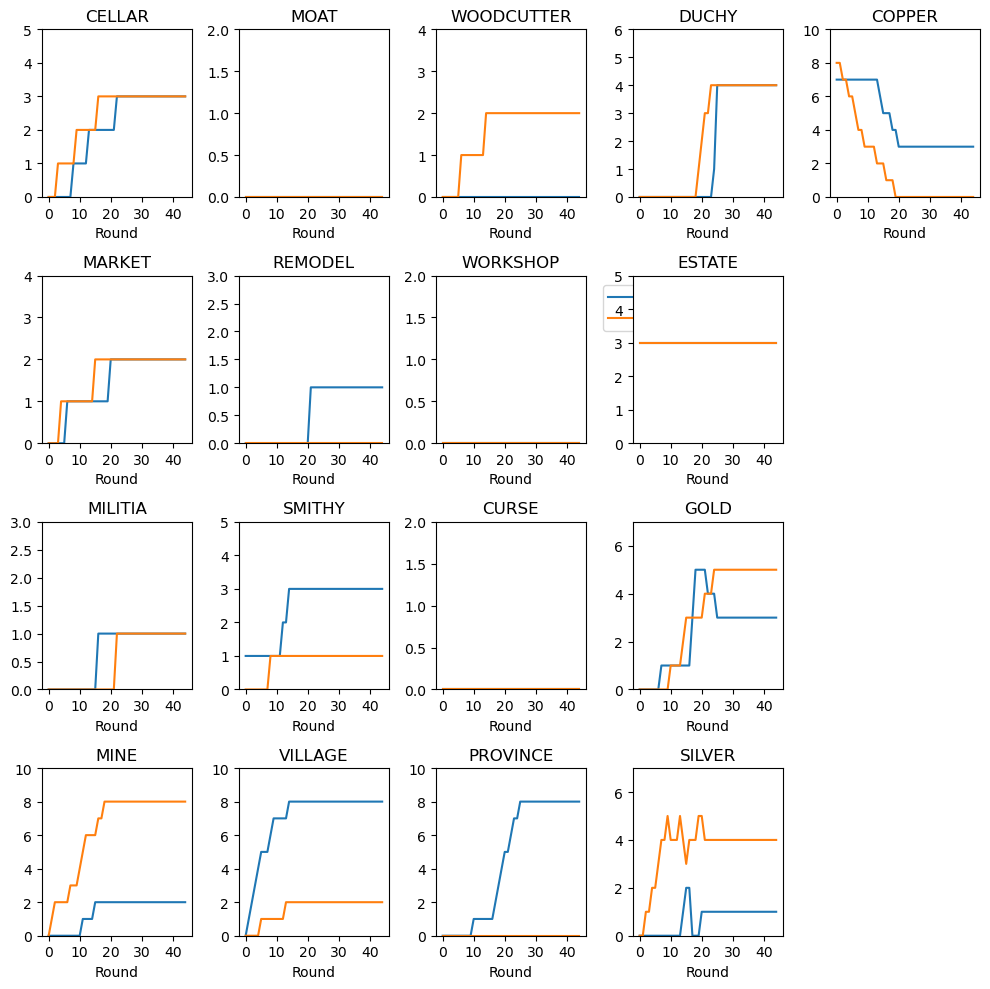

In [31]:
#examine outliers in terms of score and length of game
score_df = pd.DataFrame(score_data)
round_df = pd.DataFrame(round_data)
outlier_score_gameid = score_df['FinalScore'].astype('float').idxmax()
outlier_round_gameid = round_df['Round'].astype('float').idxmax()
outlier_score_trace_player0 = extended_traces_flat[(extended_traces_flat['GameID'] == outlier_score_gameid) & (extended_traces_flat['Player'] == 0)]
outlier_score_trace_player1 = extended_traces_flat[(extended_traces_flat['GameID'] == outlier_score_gameid) & (extended_traces_flat['Player'] == 1)]
print("Max score gameID: " + str(outlier_score_gameid))
print("Max round gameID: " + str(outlier_round_gameid))

trace_list = [outlier_score_trace_player0, outlier_score_trace_player1]
label_list = ['Final score - ' + str(outlier_score_trace_player0['FinalScore'].iloc[0]),
              'Final score - ' + str(outlier_score_trace_player1['FinalScore'].iloc[0])]
deck_evol_comparison(trace_list, label_list, card_types, maxNoOfRounds)
print(extended_traces_flat[extended_traces_flat['GameID'] == outlier_score_gameid])

No traces before outlier removal: 298
No traces after outlier removal: 282
Percentage remaining of original data set: 0.9463087248322147


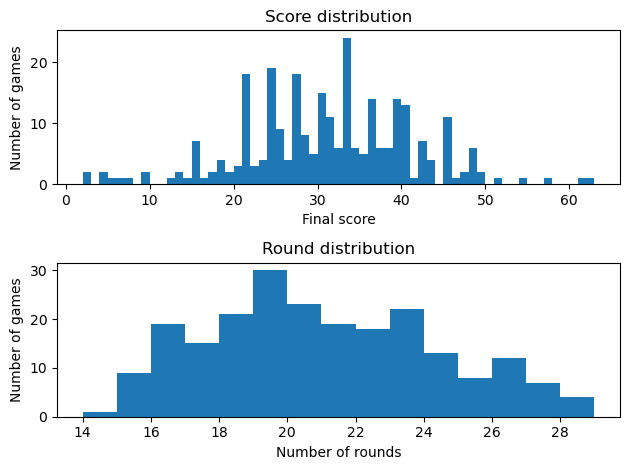

In [32]:
#remove outliers based on thresholds for score and length of game
score_threshold = 85
round_threshold = 30
extended_traces_flat_no_outliers = extended_traces_flat[(extended_traces_flat['FinalScore'] <= score_threshold)
                                           & (extended_traces_flat['TotalRounds'] <= round_threshold)]
#then re-plot score and round distributions
fig, axs = plt.subplots(2, 1)
grouped_data = extended_traces_flat_no_outliers.groupby('GameID')
score_data = grouped_data['FinalScore'].unique().explode()
axs[0].hist(score_data, bins=np.arange(score_data.min(), score_data.max()+1))
axs[0].set_xlabel('Final score')
axs[0].set_ylabel('Number of games')
axs[0].set_title('Score distribution')
round_data = grouped_data['TotalRounds'].unique().explode()
axs[1].hist(round_data, bins=np.arange(round_data.min(), round_data.max()+1))
axs[1].set_xlabel('Number of rounds')
axs[1].set_ylabel('Number of games')
axs[1].set_title('Round distribution')
fig.tight_layout() 

print("No traces before outlier removal: " + str(len(extended_traces_flat)))
print("No traces after outlier removal: " + str(len(extended_traces_flat_no_outliers)))
print("Percentage remaining of original data set: " + str(len(extended_traces_flat_no_outliers)/(1.0*len(extended_traces_flat)))) 

In [33]:
#next we compute the average traces for each combination of players and opponents, this 
#allows us to compare to the centroids computed by k-means clustering (note this is only 
#useful when we know what strategies are being employed by our AI agents or players, and 
#is used to sense check K-means in our base case scenarios)

flat_trace_tmp = extended_traces_flat_no_outliers.drop(['Player','Opponent','GameID'], axis = 1)
average_traces = flat_trace_tmp.groupby(['AgentName','AgentNameOpponent']).apply(lambda row: round(row.mean())).reset_index()
new_col_names = {old_col: old_col + '_avg' for old_col in average_traces.columns[2:]}
average_traces.rename(columns = new_col_names, inplace = True)
print(average_traces)

                      AgentName AgentNameOpponent  Win_avg  FinalScore_avg  \
0                     4thEstate       jacquilynne      0.0            24.0   
1                         AhPro     arpadTheGreat      1.0            31.0   
2                          Alan            Mariah      1.0            43.0   
3                   Alphakiller               J&D      0.0            25.0   
4                And then Louie        NewAlgebra      0.0            27.0   
..                          ...               ...      ...             ...   
199                  wakkawakka        Olompumpaa      0.0            33.0   
200                     whisper              doti      0.0            27.0   
201  ♥~Pretty Pretty Princess~♥             bennu      1.0            51.0   
202  ♥~Pretty Pretty Princess~♥      ebEliminator      1.0            45.0   
203                         エム９             Vqrpq      0.0            21.0   

     TotalRounds_avg  CELLAR_R0_avg  MARKET_R0_avg  MILITIA_R0_

In [34]:
#calculate average distances and standard deviations of individual playtraces to the
#average playtraces

def dist_measure(playTracePair, cardTypes, maxRounds, tag1, tag2):
    dist = 0
    for r in range(0, maxRounds):
        for card in cardTypes:
            col1 = card + "_R" + str(r) + tag1
            col2 = card + "_R" + str(r) + tag2
            dist += (playTracePair[col1]-playTracePair[col2])**2
    dist = math.sqrt(dist)
    return dist

distances_to_avgs_dict = {}
mean_and_std_to_avgs_list = []
for avg_trace_label in matchups:
    player, opp = avg_trace_label
    avg_trace = average_traces[(average_traces['AgentName'] == player) 
                               & (average_traces['AgentNameOpponent'] == opp)].drop(['AgentName','AgentNameOpponent'], axis = 1)
    avg_trace = pd.concat([avg_trace]*len(extended_traces_flat_no_outliers), ignore_index = True)
    avg_trace.reset_index()
    extended_traces_flat_no_outliers.reset_index()
    trace_pairs_to_avg = pd.concat([extended_traces_flat_no_outliers, avg_trace], axis = 1)
    
    #now we can compute the distance
    trace_pairs_to_avg['dist'] = trace_pairs_to_avg.apply(lambda row: dist_measure(row, card_types, maxNoOfRounds, "", "_avg"), axis = 1)
    trace_pairs_to_avg = trace_pairs_to_avg[['AgentName', 'AgentNameOpponent','dist']]
    distances_to_avgs_dict[avg_trace_label] = trace_pairs_to_avg
    
    #calculate averages and standard deviations
    results = round(trace_pairs_to_avg.groupby(['AgentName', 'AgentNameOpponent']).agg(['mean','std','count']),1).reset_index()
    results.columns = ['AgentName', 'AgentNameOpponent', 'Mean', 'Std', 'Count']
    avg_trace_label_as_str = "Avg. " + str(player) + " (vs " + str(opp) + ")"
    results['Average Trace'] = [avg_trace_label_as_str] * len(results)
    results['Average Trace Label'] = [(player,opp)] * len(results)
    results = results.reindex(columns=['AgentName', 'AgentNameOpponent', 'Average Trace','Mean', 'Std', 'Count', 'Average Trace Label'])
    mean_and_std_to_avgs_list.append(results)  

#concatenate mean and std results for each matchup
mean_and_std_to_avgs = pd.concat(mean_and_std_to_avgs_list)
mean_and_std_to_avgs = mean_and_std_to_avgs.sort_values('Mean')
print(mean_and_std_to_avgs)

NameError: name 'matchups' is not defined

In [35]:
#prepare data for kmeans
tmp =  index_cols + non_card_types_round_indep_cols
tmp  = tmp + ['Opponent','AgentNameOpponent']
trace_X = extended_traces_flat_no_outliers.drop(tmp, axis = 1)

[1.         0.83471006 0.75984327 0.71098382 0.67169257 0.64666076
 0.62448932 0.6014186  0.57832953]


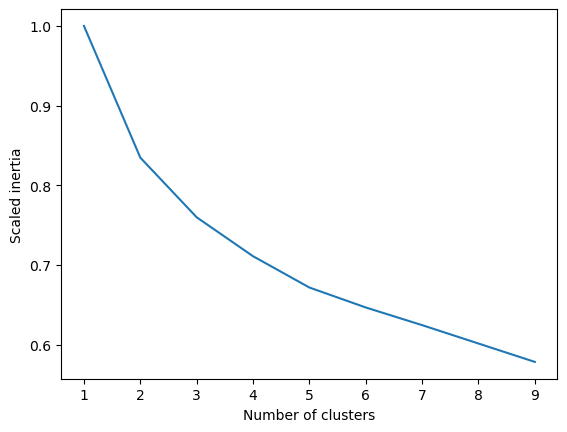

In [36]:
#inertia and elbow method
range_n_clusters = range(1, 10, 1)
inertia_vals = []
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001,
                    verbose=0, random_state= 10, copy_x=True, algorithm='lloyd')
    cluster_labels = clusterer.fit_predict(trace_X)
    inertia_vals.append(clusterer.inertia_)

#scale the inertia vals so that the first value is one
inertia_vals = np.array(inertia_vals)/inertia_vals[0]

#plot as a line plot
plt.plot(range_n_clusters, inertia_vals)
plt.xticks(range_n_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Scaled inertia")

#output inertia values
print(inertia_vals)

For n_clusters = 2 The average silhouette_score is : 0.14728855698573953
For n_clusters = 3 The average silhouette_score is : 0.12253222722862263
For n_clusters = 4 The average silhouette_score is : 0.1117132004440063
For n_clusters = 5 The average silhouette_score is : 0.10418656507164717
For n_clusters = 6 The average silhouette_score is : 0.11316006415032745


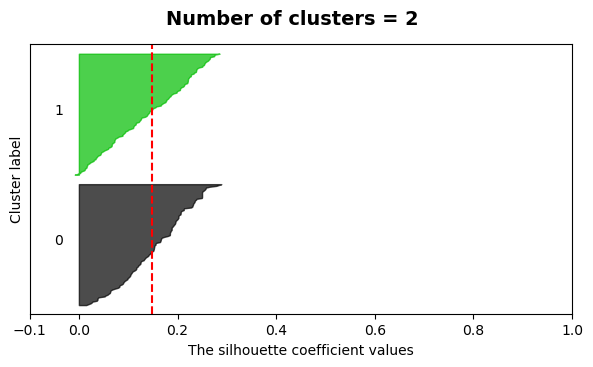

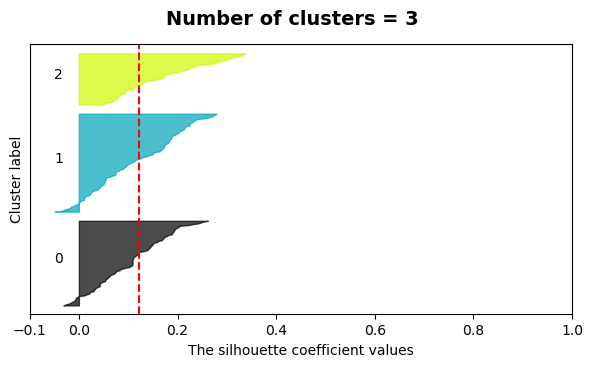

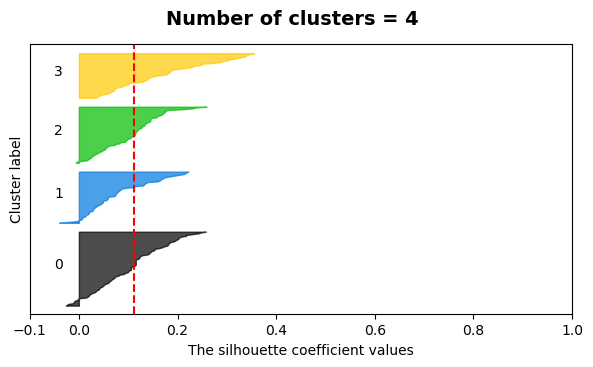

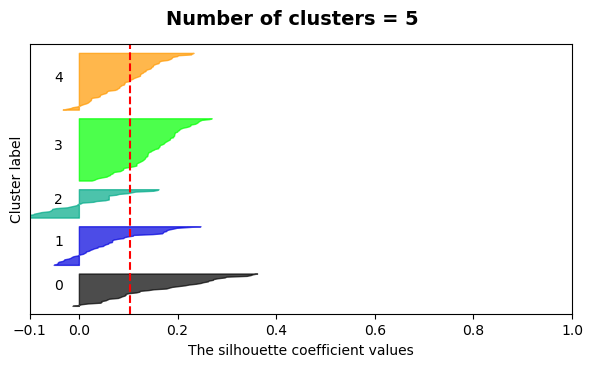

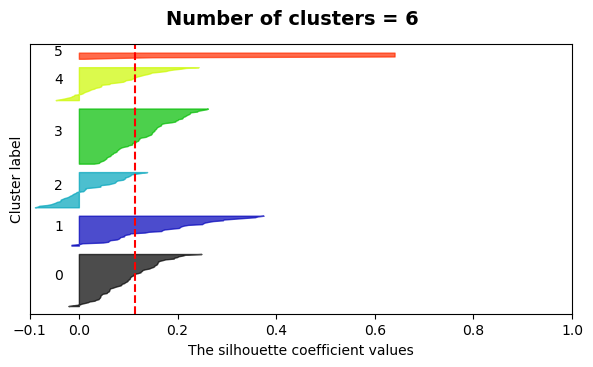

Text(0, 0.5, 'Silhouette Average')

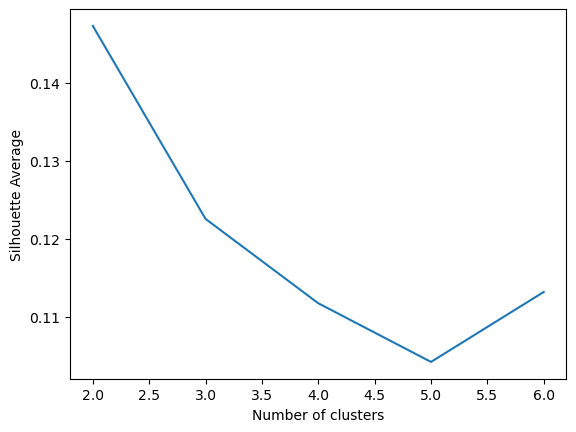

In [37]:
#next we consider three different methods for choosing the optimal number of clusters. If these dont perform well
#we will move onto the more complex approach of the gap statistic

#silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_list = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(7, 3.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(trace_X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001,
                    verbose=0, random_state= 10, copy_x=True, algorithm='lloyd')
    #cluster_labels = clusterer.fit_predict(X)
    cluster_labels = clusterer.fit_predict(trace_X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(trace_X, cluster_labels)
    silhouette_avg_list.append(silhouette_avg)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(trace_X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle(
        #"Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        "Number of clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

#also we plot just the average silhouette values by cluster number
plt.plot(range_n_clusters, silhouette_avg_list)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Average")

In [38]:
#next we want to apply k-means clustering with (euclidean distance measure) on our set of traces 
num_clusters = 2 #this needs to be set as needed
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd').fit(trace_X)

In [39]:
#add kmeans cluster classifications of traces to dataframe 
extended_traces_flat_no_outliers['ClusterID'] = kmeans.labels_
strat_vs_clusterid = extended_traces_flat_no_outliers[['AgentName', 'AgentNameOpponent','ClusterID']]
counts = strat_vs_clusterid.groupby(['AgentName', 'AgentNameOpponent','ClusterID']).size()
print(counts)

AgentName                   AgentNameOpponent  ClusterID
4thEstate                   jacquilynne        0            1
                                               1            1
AhPro                       arpadTheGreat      0            1
Alan                        Mariah             0            1
Alphakiller                 J&D                0            1
                                                           ..
whisper                     doti               0            1
                                               1            2
♥~Pretty Pretty Princess~♥  bennu              0            2
                            ebEliminator       1            1
エム９                         Vqrpq              1            1
Length: 220, dtype: int64


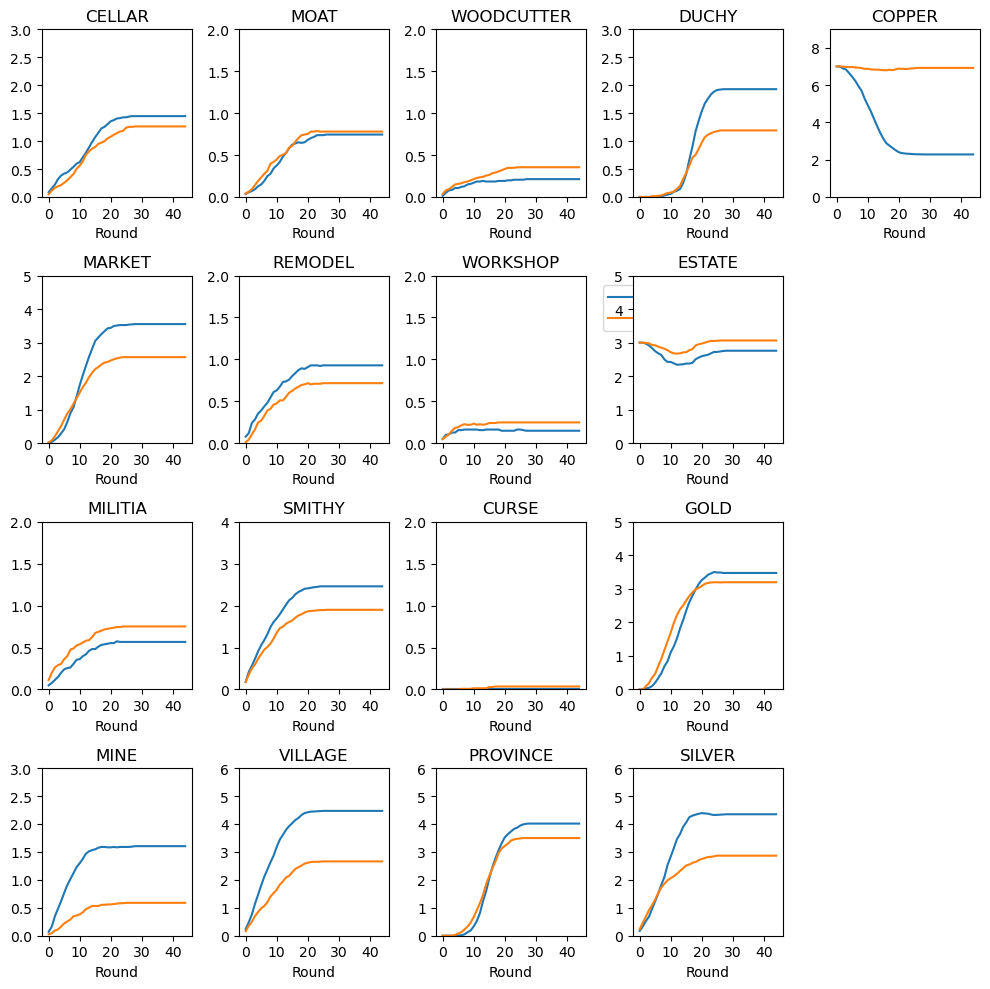

In [40]:
#compare centroids
df_cluster_centres = pd.DataFrame(kmeans.cluster_centers_)
cols = [card_types[i] + "_R" + str(r) for r in range(0, maxNoOfRounds) 
        for i in range(0, len(card_types))]
df_cluster_centres.columns = cols
cluster0centre = pd.DataFrame(df_cluster_centres.iloc[0]).transpose()
cluster1centre = pd.DataFrame(df_cluster_centres.iloc[1]).transpose()

trace_list = [cluster0centre, cluster1centre]
label_list = ['Cluster 0 Centroid', 'Cluster 1 Centroid']
deck_evol_comparison(trace_list, label_list, card_types, maxNoOfRounds)

In [41]:
#look a frequency of win rate and average final score by cluster
win_score = extended_traces_flat_no_outliers[['ClusterID', 'Win','FinalScore']]
means = win_score.groupby('ClusterID').mean()
print(means)

                Win  FinalScore
ClusterID                      
0          0.560284   32.631206
1          0.439716   28.865248


In [42]:
#look at player number by cluster - is it clustering by who goes first?
player_by_cluster = extended_traces_flat_no_outliers[['ClusterID', 'Player']]
player_mean = player_by_cluster.groupby('ClusterID').mean()
print(player_mean)

             Player
ClusterID          
0          0.439716
1          0.560284


In [43]:
#What kind of variation do we see in the evolution of the deck within a cluster?
def variation_by_card_type(data, tag, cardTypes, maxRounds):
    #look at max,min and average number of cards of each type per round
    noOfCardTypes = len(cardTypes)
    noOfSubPlotCols = 5
    noOfSubPlotRows = math.floor(noOfCardTypes/noOfSubPlotCols) + 1
    fig, axs = plt.subplots(noOfSubPlotRows, noOfSubPlotCols, figsize = (10,10))
    for i in range(0,noOfSubPlotRows):
        for j in range(0,noOfSubPlotCols):
            cardIndex = noOfSubPlotRows*j + i
            if cardIndex >= len(cardTypes):
                axs[i,j].set_visible(False)
            else:
                cardType = cardTypes[cardIndex]
                avg_vals = []
                std_vals = []
                for r in range(0, maxRounds):
                    col = cardType + "_R" + str(r) + tag
                    avg_vals.append(data[col].mean())
                    std_vals.append(data[col].std())

                #compute average plus or minus one standard deviation
                avg_minus_one_std = np.array(avg_vals) - np.array(std_vals)
                avg_minus_one_std = [max(0,x) for x in avg_minus_one_std]
                avg_plus_one_std = np.array(avg_vals) + np.array(std_vals)

                axs[i,j].plot(range(0,maxRounds), avg_vals, label = 'Average')
                axs[i,j].plot(range(0,maxRounds), avg_minus_one_std, label = 'Avg minus one std', linestyle = 'dashed')
                axs[i,j].plot(range(0,maxRounds), avg_plus_one_std, label = 'Avg plus one std', linestyle = 'dashed')
                axs[i,j].set_title(cardType)
                axs[i,j].set_xlabel('Round')
                axs[i,j].set_ylim((0,max(avg_plus_one_std)+1))
                axs[i,j].set_xticks(ticks = range(0, maxRounds,10))

    #tighten subplots layout
    fig.tight_layout() 
    
    #add overal legend to figure
    axs[0,noOfSubPlotRows - 1].legend(loc = (-0.2,-0.8))

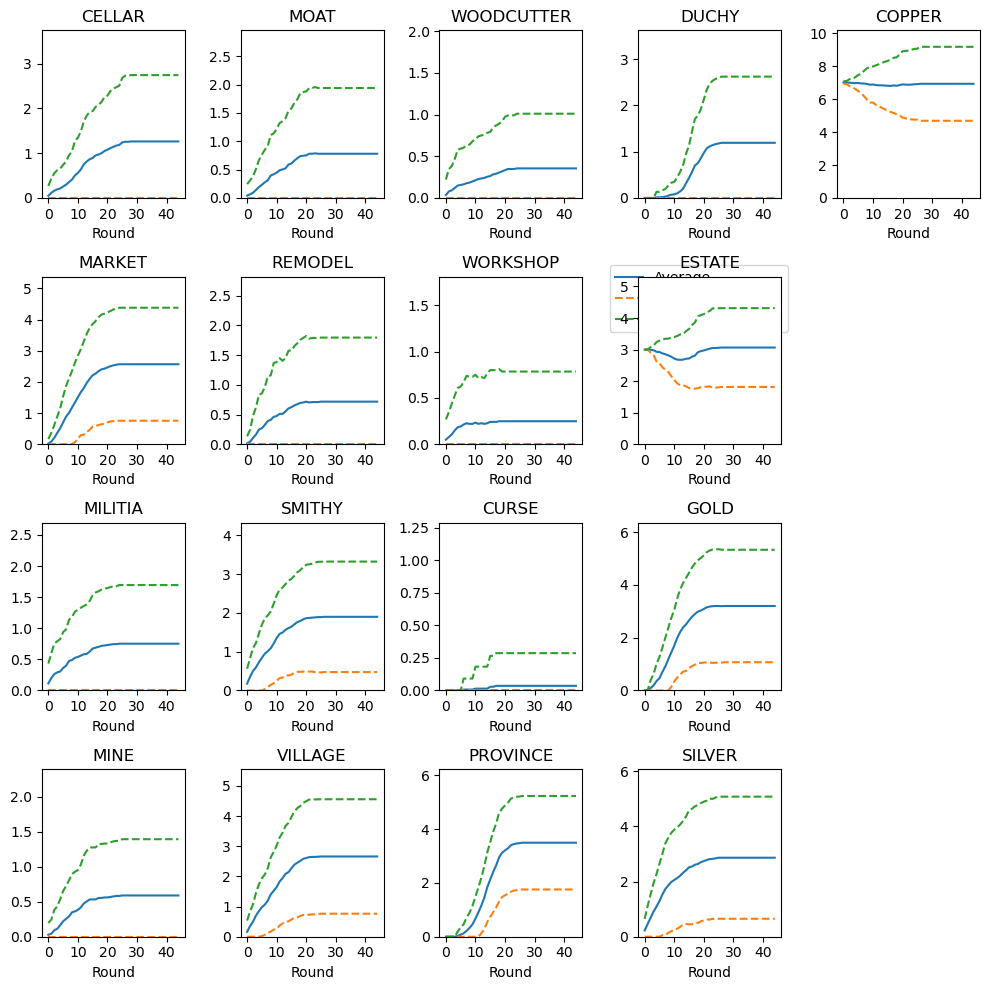

In [44]:
cluster_one_data = extended_traces_flat_no_outliers[extended_traces_flat_no_outliers['ClusterID'] == 1.0]
variation_by_card_type(cluster_one_data, "", card_types, maxNoOfRounds)

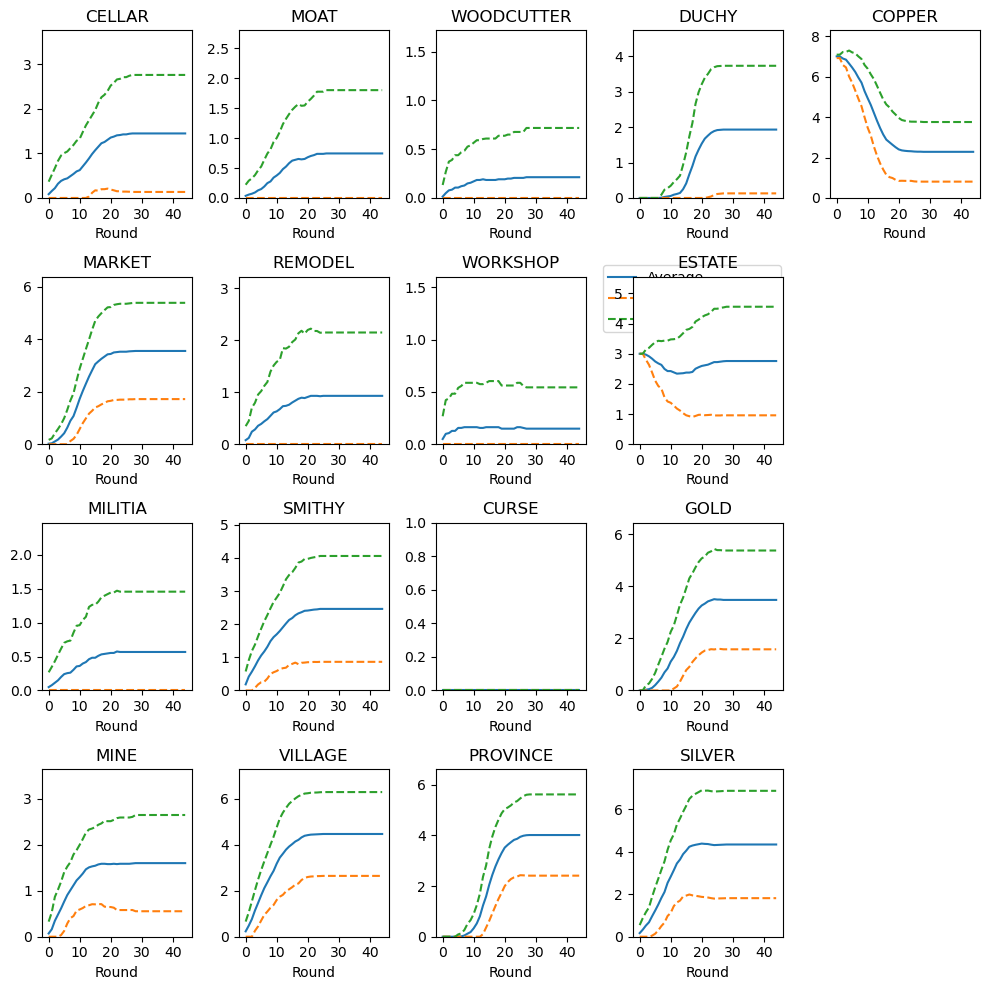

In [45]:
cluster_zero_data = extended_traces_flat_no_outliers[extended_traces_flat_no_outliers['ClusterID'] == 0.0]
variation_by_card_type(cluster_zero_data, "", card_types, maxNoOfRounds)

In [46]:
#compare evolution between clusters including error bounds
def variation_by_card_type_comparison(data1, data2, title1, title2, cardTypes, maxRounds):
    for card in cardTypes:
        fig, axs = plt.subplots(figsize = (9,5))
        datacounter = 0
        for data in [data1, data2]:
            title = title1
            linestyle_type = 'dotted'
            avg_color = 'darkgreen'
            std_color = 'green'
            if datacounter == 1:
                title = title2
                linestyle_type = 'dashed'
                avg_color = 'darkblue'
                std_color = 'blue'
            avg_vals = []
            std_vals = []
            for r in range(0, maxRounds):
                col = card + "_R" + str(r) 
                avg_vals.append(data[col].mean())
                std_vals.append(data[col].std())
                
            #compute average plus or minus one standard deviation
            avg_minus_one_std = np.array(avg_vals) - np.array(std_vals)
            avg_minus_one_std = [max(0,x) for x in avg_minus_one_std]
            avg_plus_one_std = np.array(avg_vals) + np.array(std_vals)
    
            axs.plot(range(0,maxRounds), avg_vals, color = avg_color, label = title + ' - Average')
            axs.plot(range(0,maxRounds), avg_minus_one_std, color = std_color, label = title + ' - Avg minus one std', linestyle = linestyle_type)
            axs.plot(range(0,maxRounds), avg_plus_one_std, color = std_color, label = title + ' - Avg plus one std', linestyle = linestyle_type)
            
            axs.set_title(card)
            axs.set_xlabel('Round')
            axs.set_xticks(ticks = range(0, maxRounds,10))
            axs.legend(loc = (1.1,0.68))
            datacounter += 1
        
        #tighten subplots layout
        #fig.ylim(0,5)
        fig.tight_layout() 
        #fig.legend(loc = (0.7,0.9))
        #fig.tight_layout() 
            
    #add overal legend to figure
    #axs[0,4].legend(loc = (1.2,0.7))

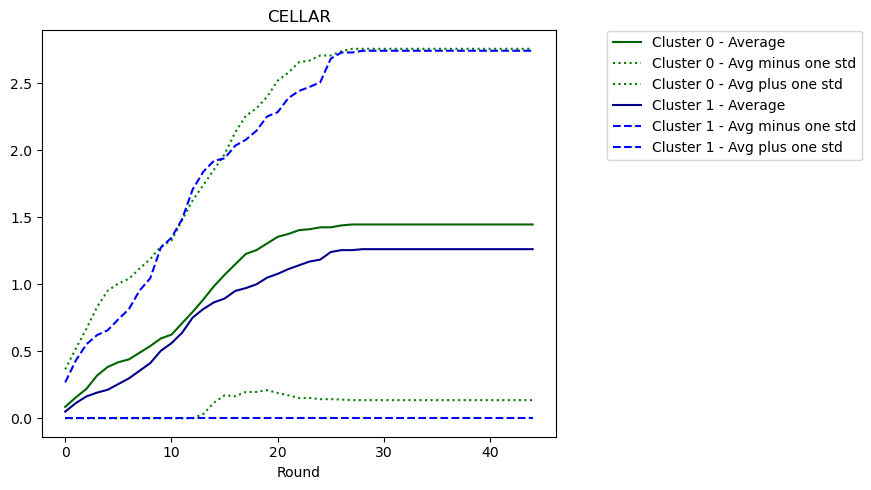

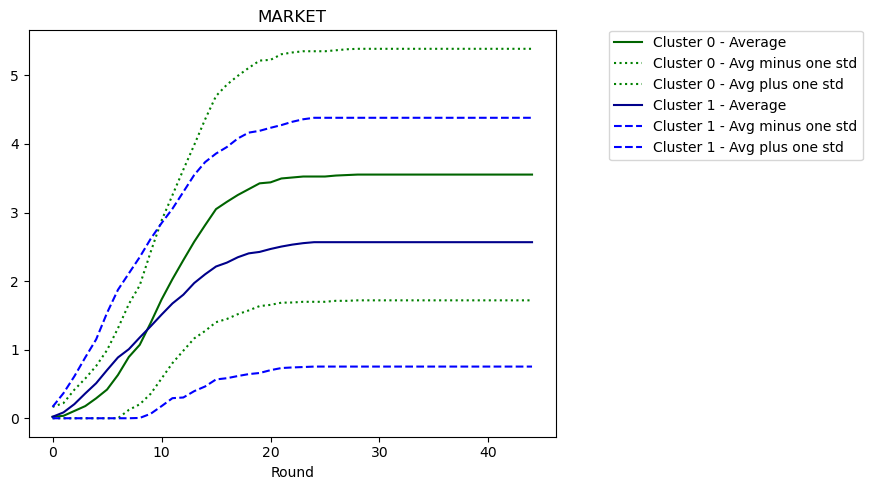

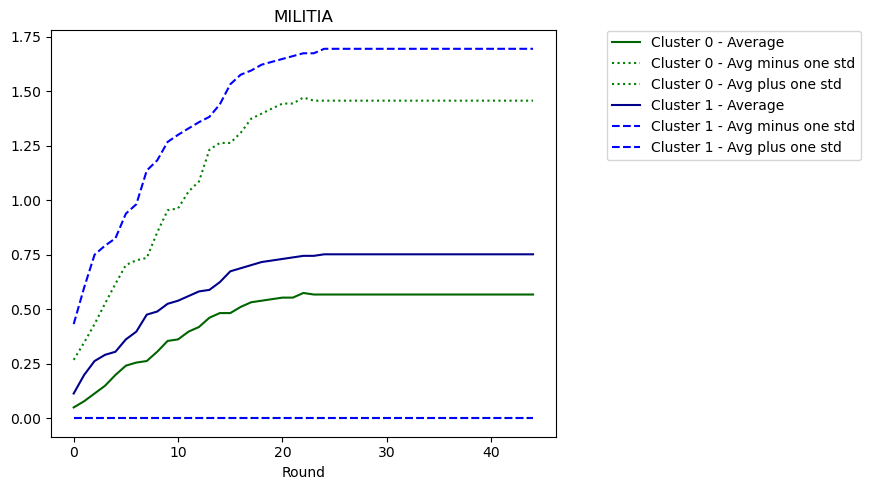

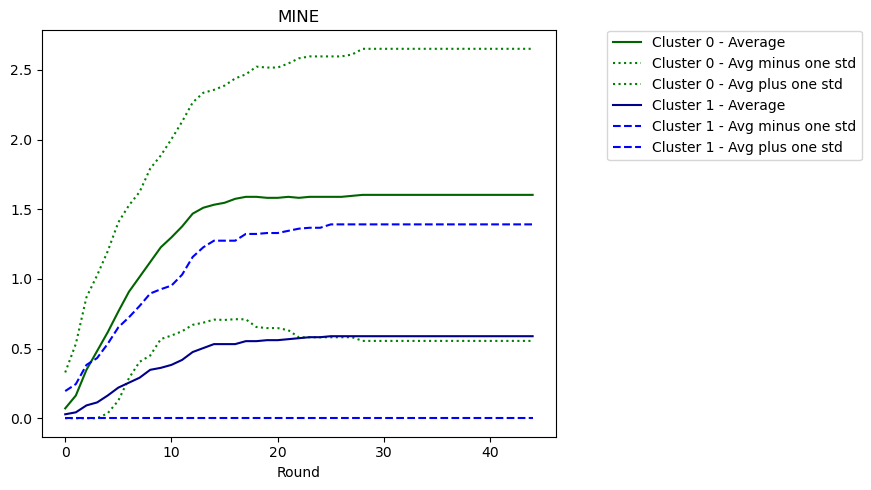

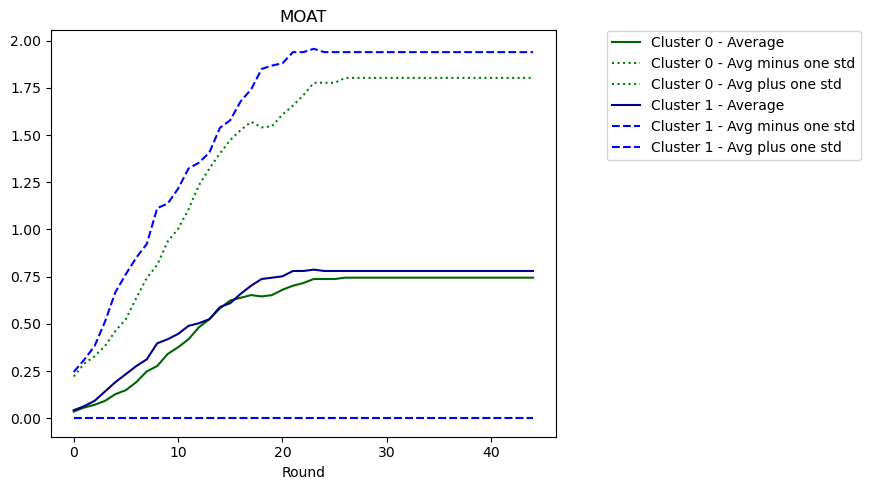

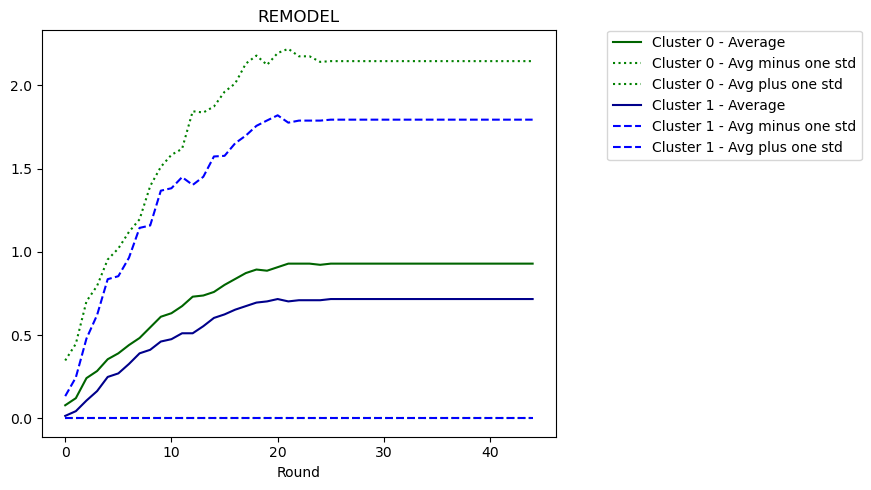

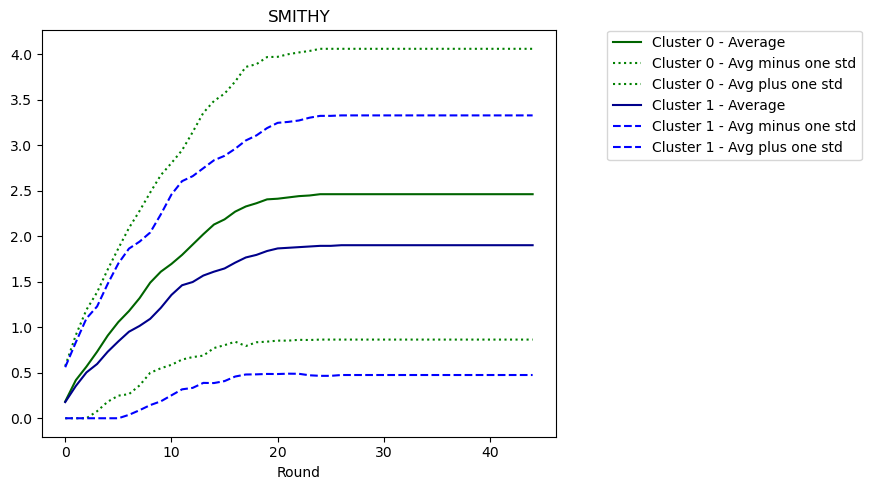

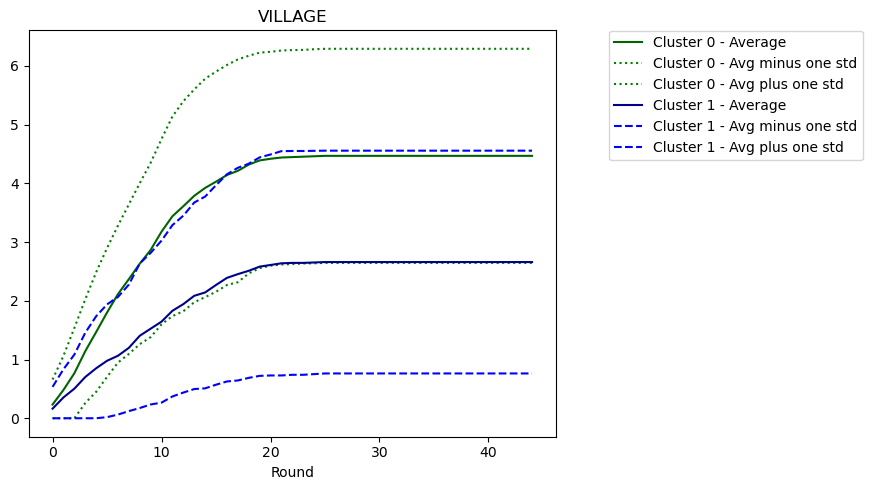

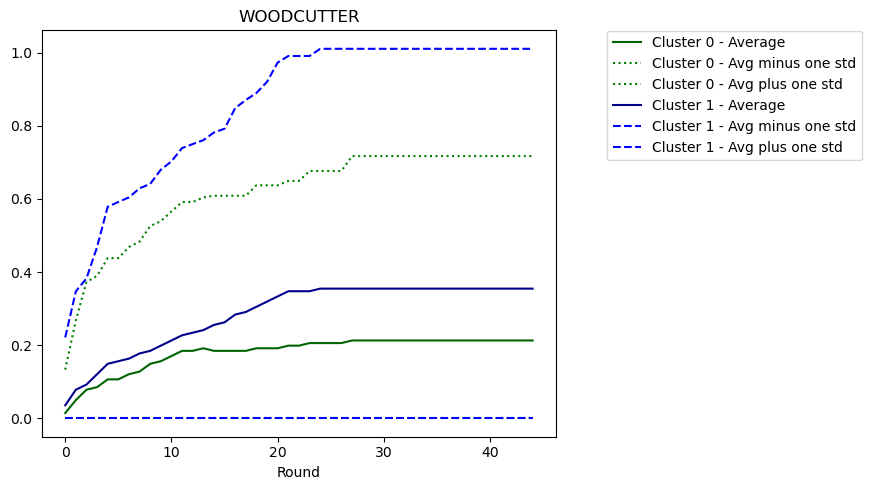

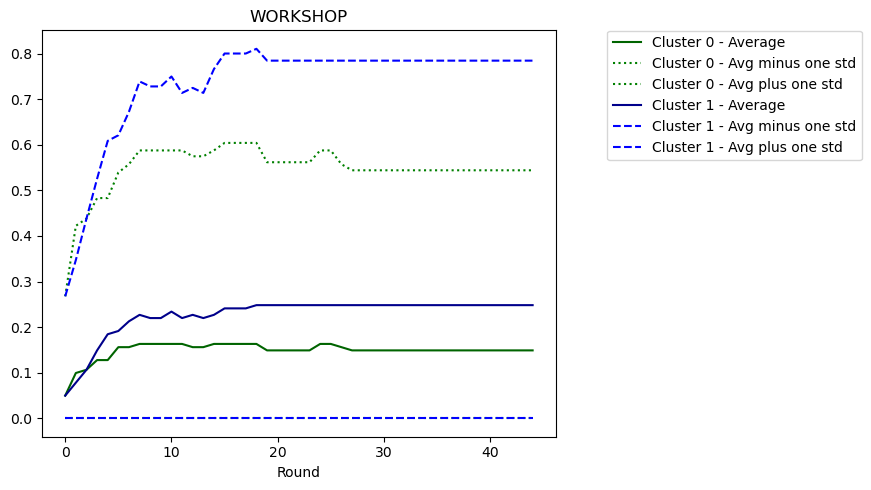

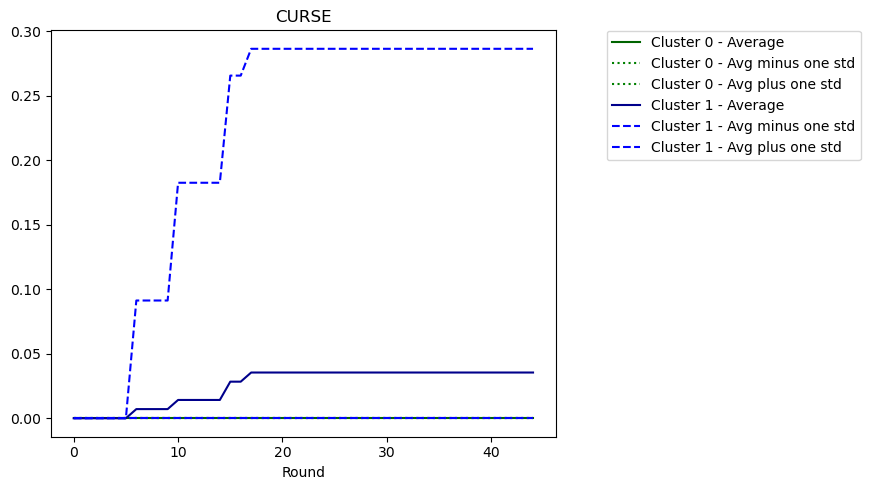

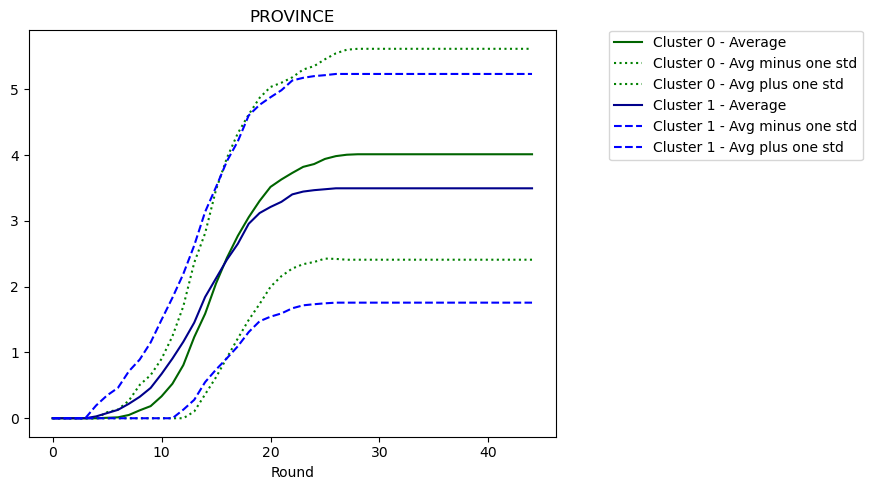

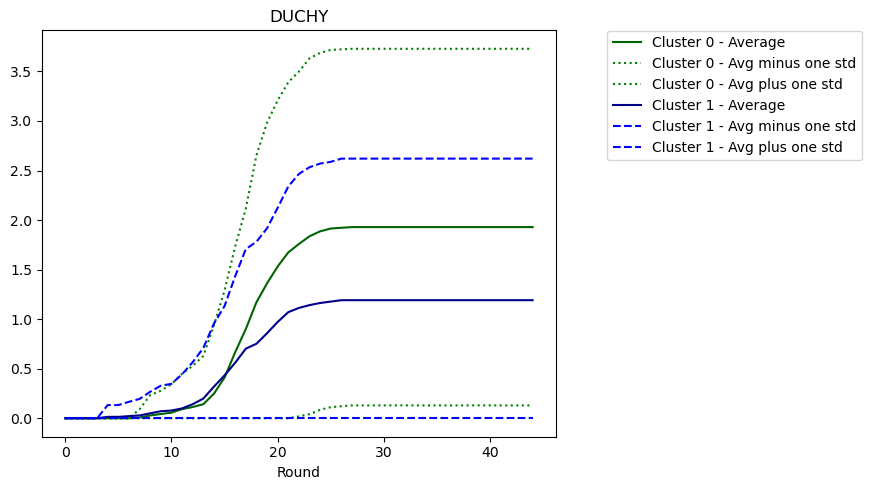

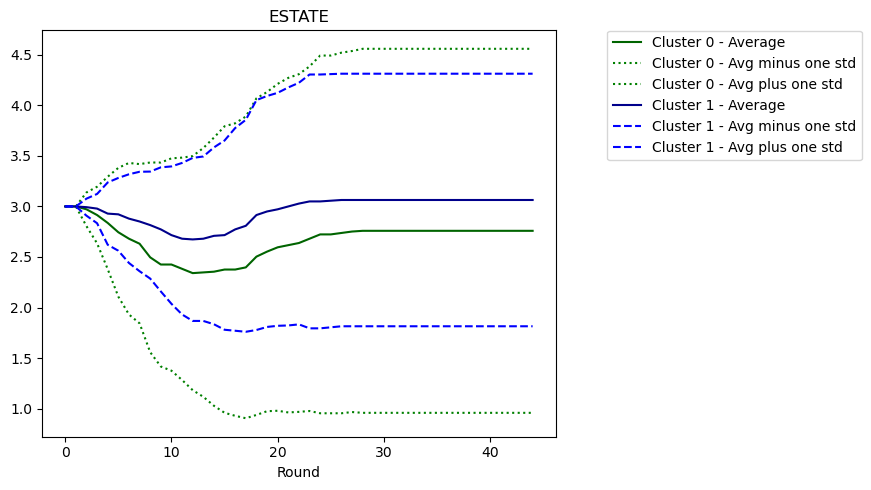

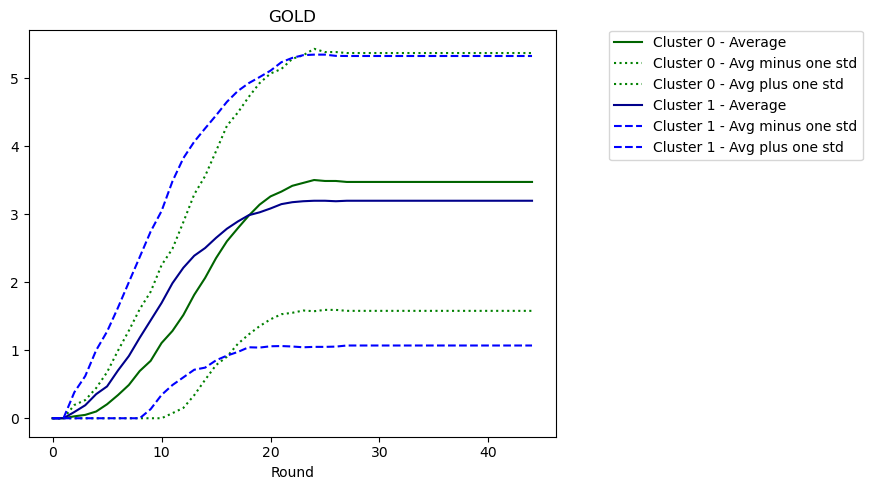

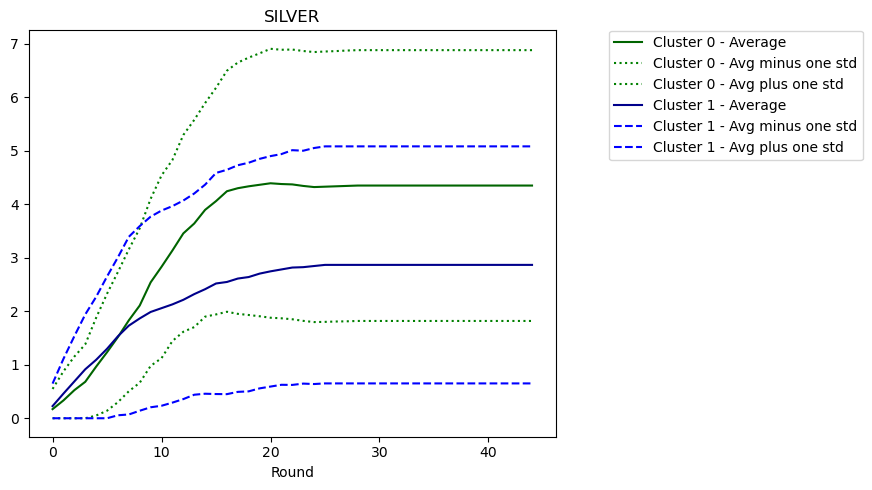

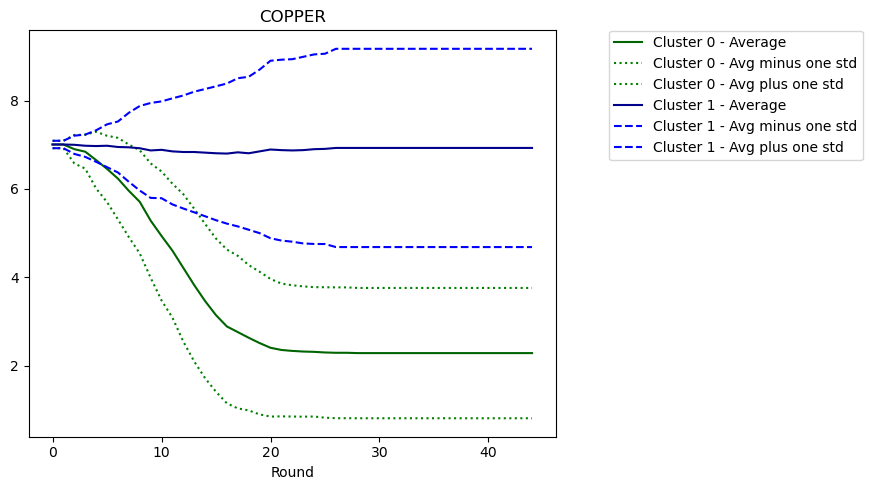

In [47]:
variation_by_card_type_comparison(cluster_zero_data, cluster_one_data, 'Cluster 0', 'Cluster 1', card_types, maxNoOfRounds)

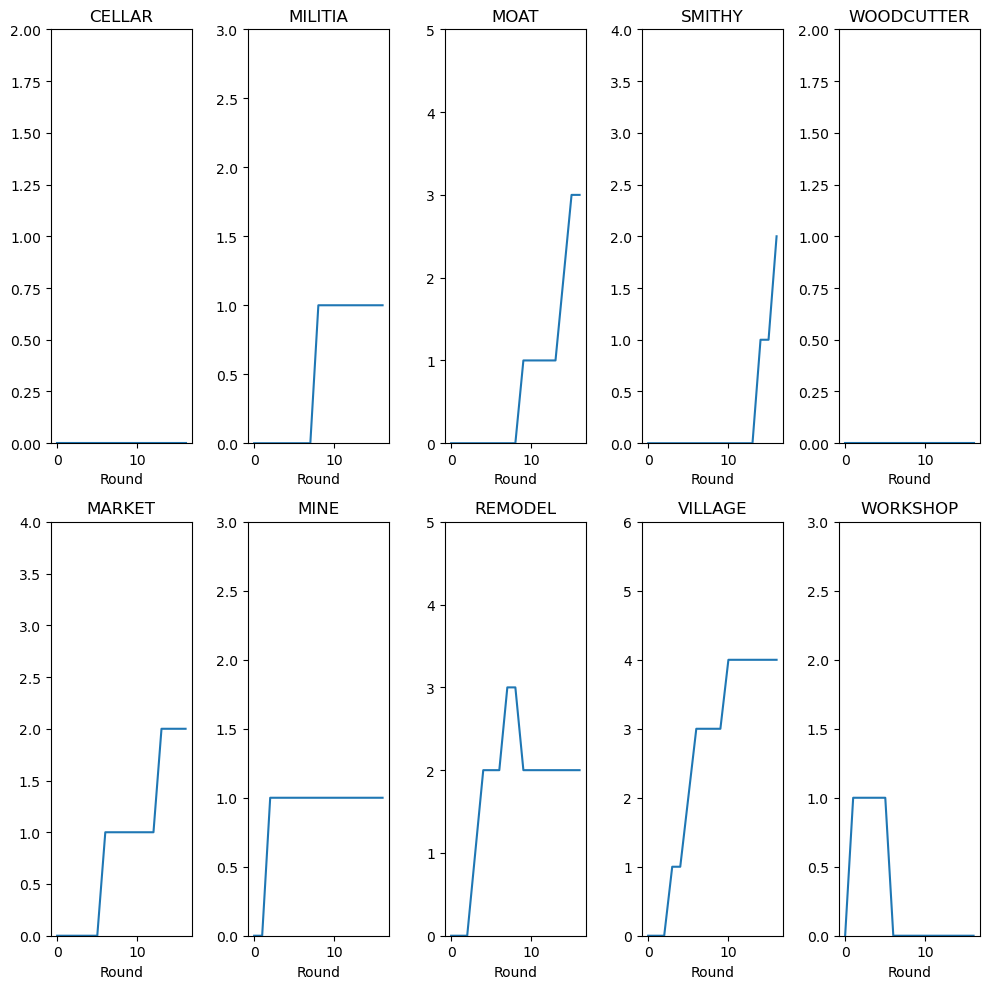

In [48]:
#plot a single play-trace, useful for illustration purposes 
def plot_single_trace(trace, labelname, cardTypes, maxRounds):
    noOfCardTypes = len(cardTypes)
    noOfSubplotsInXDirection = noOfCardTypes % 5 
    noOfSubplotsInYDirection = min(5, noOfCardTypes)
    fig, axs = plt.subplots(noOfSubplotsInXDirection, noOfSubplotsInYDirection, figsize = (10,10))
    for i in range(0,noOfSubplotsInXDirection):
        for j in range(0,noOfSubplotsInYDirection):
            cardIndex = noOfSubplotsInXDirection*j + i
            if cardIndex >= len(cardTypes):
                axs[i,j].set_visible(False)
            else:
                cardType = cardTypes[cardIndex]
                card_col = [cardType + "_R" + str(r) for r in range(0,maxRounds)]
                axs[i,j].plot(range(0,maxRounds), trace[card_col].iloc[0], label = labelname)
                axs[i,j].set_title(cardType)
                axs[i,j].set_xlabel('Round')

                #set y limits 
                card_max = int(trace[card_col].iloc[0].max())

                #pdb.set_trace()
                axs[i,j].set_ylim((0,card_max+2))
                axs[i,j].set_xticks(ticks = range(0, maxRounds,10))
            
    #tighten subplots layout
    fig.tight_layout() 
    
    #add overal legend to figure
    #axs[0,4].legend(loc = (1.2,0.7))
    
single_trace = extended_traces_flat_no_outliers[(extended_traces_flat_no_outliers['GameID'] == 2) & (extended_traces_flat_no_outliers['Player'] == 0)]
plot_single_trace(single_trace, 'example trace', card_types, 17)

1.5521437841892696


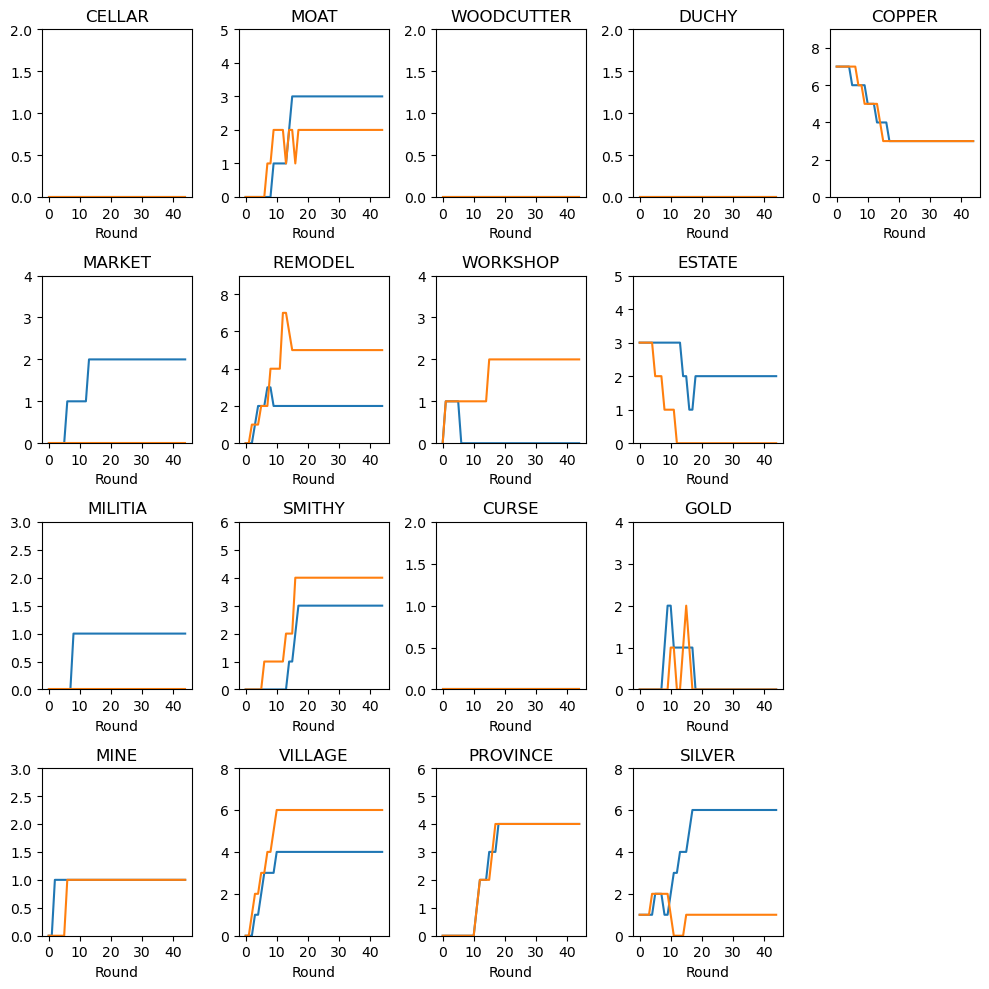

In [49]:
#comparing two play traces and calculating the distance measure
def dist(trace1, trace2, cardTypes, maxRounds):
    card_col = [card + "_R" + str(r) for card in cardTypes for r in range(0,maxRounds)]
    distance = 0
    for entry in card_col:
        distance += math.pow(trace1[entry].iloc[0] - trace2[entry].iloc[0],2.0)
    distance = math.sqrt(distance/len(card_col))
    return distance

trace_1 = extended_traces_flat_no_outliers[(extended_traces_flat_no_outliers['GameID'] == 2) & (extended_traces_flat_no_outliers['Player'] == 0)]
trace_2 = extended_traces_flat_no_outliers[(extended_traces_flat_no_outliers['GameID'] == 2) & (extended_traces_flat_no_outliers['Player'] == 1)]
print(dist(trace_1,trace_2,card_types, maxNoOfRounds))

trace_list = [trace_1,trace_2]
label_list = ['','']
deck_evol_comparison(trace_list, label_list, card_types, maxNoOfRounds, legendOn = False)


In [ ]:
#What are the unconditional probabilities of seeing a particular card in beginning, mid, late game?

In [ ]:
#What are the conditional probabilities of seeing a particular card in beginning, mid, late game given another card exists
#in the deck?